![Title Diagram](./images/title2.png)

---

## 🧭 Agenda

This demo walks through the end-to-end process of **Reinforcement Fine-Tuning (RFT)** using the `o4-mini` reasoning model on Azure OpenAI:

1. **Dataset & Objective**  
   
2. **System Prompt & Grader Setup**  
   
3. **Evaluating Base Models**  
   
4. **RFT Training: Setup, Launch & Monitoring**  
   
5. **Results & Completion Comparison**  
   
6. **Key Takeaways**  
   

---

## 🧮 Section 1: Dataset & Objective

In this demo, we use the **Countdown** dataset from Predibase — inspired by the UK game show where players must reach a target number using arithmetic and a limited set of numbers.

Each example contains:
- A **target number** (e.g., 97)
- A **list of four integers** (e.g., [53, 99, 45, 37])

The model’s task is to generate an arithmetic expression using those four numbers to match (or get close to) the target.

✅ Example:  
`(99 - ((53 + 37) / 45)) ≈ 97`

---

### 🔧 Additional Constraint

We make the task stricter:

> 🧩 **All four numbers must be used exactly once** in the final expression.

This encourages:
- Structured, multi-step reasoning  
- Full utilization of all inputs  
- Output formats that generalize well

---

### 🧠 Why This Is a Perfect Fit for RFT

This task is **not ideal for Supervised Fine-Tuning (SFT)**, which requires exact output labels. Here:
- There are **many valid outputs** per input
- **Evaluating correctness is easy**, but **generating the correct form is hard**
- Reward-based learning works far better than forcing the model to mimic a single path

With RFT:
- The model learns from **graded outcomes** instead of fixed answers
- We can **reinforce desired behavior** using numeric reward from a custom grader
- It's well suited for **low-data**, **high-structure** domains — like code, logic, or reasoning

---

### 🔍 Previewing the Data

Let’s load and display a few samples from the dataset to understand the format we’ll be working with:

In [1]:
from datasets import load_dataset
import random
import json

# Load the Countdown dataset (train split)
dataset = load_dataset("predibase/countdown", split="train")

# Display 5 random samples
print("🎯 Countdown Dataset Samples\n" + "-" * 40)
for i in random.sample(range(len(dataset)), 5):
    item = dataset[i]
    print(f"Target     : {item['target']}")
    print(f"Numbers    : {item['nums']}")
    print("-" * 40)


c:\Users\omkarm\AppData\Local\anaconda3\envs\openai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🎯 Countdown Dataset Samples
----------------------------------------
Target     : 84
Numbers    : [12, 87, 80]
----------------------------------------
Target     : 75
Numbers    : [54, 10, 31]
----------------------------------------
Target     : 56
Numbers    : [7, 63, 7, 21]
----------------------------------------
Target     : 39
Numbers    : [65, 9, 35]
----------------------------------------
Target     : 24
Numbers    : [25, 48, 16, 65]
----------------------------------------


## 🧩 Section 2: System Prompt, Response Scema & Grader Setup

To enable Reinforcement Fine-Tuning, we configure three key components: a structured prompt, a strict output schema, and a model-based grader.

![Section2 Diagram](images/md_sp_rs_cg.PNG)

---

### 💬 System Prompt

This guides the model on how to solve the Countdown-style problem and return results in a JSON structure.

In [2]:
# 💬 System Prompt used during RFT training and evaluation
instruction = (
    "You are an expert in arithmetic problem solving. Given a target number and a list of numbers, "
    "your task is to combine all of the numbers exactly once using addition (+), subtraction (-), "
    "multiplication (x), or division (÷) to reach the target.\n\n"
    "- You must use every number exactly once.\n"
    "- Use parentheses as needed to control the order of operations.\n"
    "- Return only a valid JSON object with the following exact syntax:\n"
    "  {\n    \"expression\": \"...\",\n    \"result\": \"...\"\n  }\n"
    "- Both the expression and the result must be returned as strings.\n"
    "- If the exact target is not possible, return the closest valid result using all numbers.\n\n"
    "Example 1\nTarget: 850\nNumbers: [100, 75, 50, 25, 6, 3]\nOutput:\n"
    "{\n  \"expression\": \"((100 * 6) + (75 + 25) + (3 * 50))\",\n  \"result\": \"850\"\n}\n\n"
    "Example 2\nTarget: 945\nNumbers: [25, 100, 9, 3, 6, 2]\nOutput:\n"
    "{\n  \"expression\": \"((100 * 9) + (6 * 3) + (25 + 2))\",\n  \"result\": \"945\"\n}\n\n"
    "Example 3\nTarget: 310\nNumbers: [7, 50, 75, 3, 8, 2]\nOutput:\n"
    "{\n  \"expression\": \"((75 * 3) + (50 * 2) - (8 + 7))\",\n  \"result\": \"310\"\n}\n\n"
)

### 📦 Response Schema

To ensure the model outputs are machine-readable and consistent, we define a **response schema** that:
- Requires two fields: `"expression"` and `"result"`
- Enforces that both are strings
- Rejects completions that include extra or malformed content

This schema will be used during both **evaluation** and **fine-tuning**.

In [4]:

# 📦 JSON Schema for RFT output validation
response_schema = {
    "type": "json_schema",
    "json_schema": {
        "name": "math_expression",
        "schema": {
            "type": "object",
            "required": ["expression", "result"],
            "properties": {
                "expression": {
                    "type": "string",
                    "description": "The mathematical expression to be evaluated."
                },
                "result": {
                    "type": "string",
                    "description": "The result of evaluating the mathematical expression."
                }
            },
            "additionalProperties": False
        },
        "strict": True
    }
}

For this demo, we will use python grader for both evals and RFT.

### 🧠 Custom Grader (Code-Based)

Instead of relying on hardcoded logic, we use a **code-based grader** (`python`) that evaluates each completion and scores it from **0 to 5** based on:
- Expression validity
- Correct usage of all numbers
- Proximity to the target result

The grader provides both a **numeric score**.

This grader receives:
- A **target number** (as a string)
- A **list of numbers** (as a stringified list)
- A **model-generated output expression** (along with the result it claims)

The grader then:
- Parses and evaluates the arithmetic expression
- Verifies that **all numbers are used exactly once**
- Compares the evaluated result with the target
- Returns a score from **0 to 5** with reasoning

**🎯 Scoring Rubric**

| Score | Description |
|-------|-------------|
| 5     | Expression is valid, uses all numbers exactly once, and matches the target |
| 4     | Off by ±1, everything else correct |
| 3     | Off by ±2–5, with valid expression and number usage |
| 2     | Off by >5, but still valid and complete |
| 1     | Minor issues (e.g., reused or missing numbers) |
| 0     | Invalid expression or incorrect number usage |

Following is the python code that will be used to grade model response:
```python
import json, re, ast


def safe_eval(e):
    return _eval(ast.parse(e, mode='eval').body)


def _eval(n):
    if isinstance(n, ast.Constant):
        return n.value

    if isinstance(n, ast.BinOp) and type(n.op) in {
        ast.Add: lambda a, b: a + b,
        ast.Sub: lambda a, b: a - b,
        ast.Mult: lambda a, b: a * b,
        ast.Div: lambda a, b: a / b,
        ast.FloorDiv: lambda a, b: a // b,
        ast.Mod: lambda a, b: a % b,
        ast.Pow: lambda a, b: a ** b,
    }:
        return {
            ast.Add: lambda a, b: a + b,
            ast.Sub: lambda a, b: a - b,
            ast.Mult: lambda a, b: a * b,
            ast.Div: lambda a, b: a / b,
            ast.FloorDiv: lambda a, b: a // b,
            ast.Mod: lambda a, b: a % b,
            ast.Pow: lambda a, b: a ** b,
        }[type(n.op)](_eval(n.left), _eval(n.right))

    if isinstance(n, ast.UnaryOp) and type(n.op) in {
        ast.UAdd: lambda a: +a,
        ast.USub: lambda a: -a,
    }:
        return {
            ast.UAdd: lambda a: +a,
            ast.USub: lambda a: -a,
        }[type(n.op)](_eval(n.operand))

    raise ValueError('bad expr')


def grade(sample, item) -> float:
    try:
        expr = sample['output_json']['expression']
        expr_val = safe_eval(expr)

        # Check numbers used
        if sorted(map(int, re.findall(r'-?\d+', expr))) != sorted(
            map(int, json.loads(item['nums']))
        ):
            return 0

        sr = int(float(sample['output_json']['result']))
        it = int(float(item['target']))

        if expr_val != sr:
            return 1
        if sr == it:
            return 5
        if abs(sr - it) <= 1:
            return 4
        if abs(sr - it) <= 5:
            return 3
        return 2

    except:
        return 0
``

In [ ]:
# 🎯 Custom Grader (python) for RFT
custom_grader = {
    "type": "python",
    "source": "import json,re,ast\n\ndef safe_eval(e):\n    return _eval(ast.parse(e,mode='eval').body)\n\ndef _eval(n):\n    if isinstance(n,ast.Constant):return n.value\n    if isinstance(n,ast.BinOp) and type(n.op) in {ast.Add:lambda a,b:a+b,ast.Sub:lambda a,b:a-b,ast.Mult:lambda a,b:a*b,ast.Div:lambda a,b:a/b,ast.FloorDiv:lambda a,b:a//b,ast.Mod:lambda a,b:a%b,ast.Pow:lambda a,b:a**b}:return {ast.Add:lambda a,b:a+b,ast.Sub:lambda a,b:a-b,ast.Mult:lambda a,b:a*b,ast.Div:lambda a,b:a/b,ast.FloorDiv:lambda a,b:a//b,ast.Mod:lambda a,b:a%b,ast.Pow:lambda a,b:a**b}[type(n.op)](_eval(n.left),_eval(n.right))\n    if isinstance(n,ast.UnaryOp) and type(n.op) in {ast.UAdd:lambda a:+a,ast.USub:lambda a:-a}:return {ast.UAdd:lambda a:+a,ast.USub:lambda a:-a}[type(n.op)](_eval(n.operand))\n    raise ValueError('bad expr')\n\ndef grade(sample,item)->float:\n    try:\n        expr=sample['output_json']['expression'];expr_val=safe_eval(expr)\n        if sorted(map(int,re.findall(r'-?\\d+',expr)))!=sorted(map(int,json.loads(item['nums']))):return 0\n        sr,it=int(float(sample['output_json']['result'])),int(float(item['target']))\n        if expr_val!=sr:return 1\n        if sr==it:return 5\n        if abs(sr-it)<=1:return 4\n        if abs(sr-it)<=5:return 3\n        return 2\n    except: return 0"
}

## 📊 Section 3: Evaluating Base Models

Before fine-tuning, we evaluate how existing models perform on the Countdown task using our custom **o3-mini-based grader**.

We compare:
- `o3` (large reasoning model)
- `o4-mini` (smaller reasoning model)
- `gpt-4.1` and `gpt-4.1-mini` (general-purpose models)

All models are evaluated on the same set of examples using the same rubric:
- Use all numbers once
- Return valid expression and result
- Get as close as possible to the target

---

### 🎯 Evaluation Setup
- We reuse the same **eval dataset** for all models
- Each model is run using the **Azure OpenAI evaluation API**
- The custom grader assigns a score from **0–5** per example

---

### 📈 What We're Measuring

| Metric              | Description                                                        |
|---------------------|--------------------------------------------------------------------|
| **Pass %**          | % of completions that passed (score ≥ threshold, e.g., 5)          |
| **Error %**         | % of completions that failed structurally (e.g., malformed output) |

---




### 📦 Step 1: Preparing Dataset for Evaluation

We use a small subset of the Countdown dataset (100 examples) for evaluation.  
Each record includes a `target`, a list of numbers (`nums`), and will later be compared to model completions using our custom grader.


In [7]:
from datasets import load_dataset
from scripts.dataset_utils import save_dataset_in_eval_format
import json

# Load test split of Countdown dataset
test_dataset = load_dataset("predibase/countdown", split="test")

eval_ready_path = "data/countdown_eval_100.jsonl"

# Save in the grader-compatible format
save_dataset_in_eval_format(test_dataset, eval_ready_path, max_records=100)

✅ Saved 100 records to data/countdown_eval_100.jsonl in evaluation format (only samples with 4 nums)


### ☁️ Step 2: Uploading Evaluation Dataset & Running Base Model Evaluations

We now upload the evaluation dataset to Azure OpenAI and run it against four base models:

- `o3`
- `o4-mini`
- `gpt-4.1`
- `gpt-4.1-mini`

Each run will:
- Use the same eval dataset
- Be scored by the **custom grader** (`o3-mini`)
- Output pass %, error %, and detailed scores


In [ ]:
from scripts.io_utils import upload_file
from scripts.eval_utils import create_eval_run

# Upload the evaluation file to Azure OpenAI
eval_file_id = await upload_file(file_name="countdown_evals_100.jsonl", file_path=eval_ready_path, purpose="evals")
print(f"✅ Eval file ID: {eval_file_id}")

Using Azure API for file upload...
File 'countdown_evals_100.jsonl' already exists on Azure. Returning existing file ID.
✅ Eval file ID: file-1b66572703ce4fde99e1891113afd384


In [ ]:
from scripts.eval_utils import create_eval_python_grader

eval_id = await create_eval_python_grader("python-grader-countdown", pass_threshold=5)
print(f"📊 Evaluation created with ID: {eval_id}")
# Define model deployments to evaluate
RUN_MODEL_DEPLOYMENTS = [
    "o3",
    "o4-mini",
    "gpt-4.1",
    "gpt-4.1-mini"
]

# Launch eval runs for each model
for deployment in RUN_MODEL_DEPLOYMENTS:
    await create_eval_run(eval_id, eval_file_id, model_deployment=deployment, system_prompt=instruction)

print(f"🚀 Evaluation runs launched for models: {', '.join(RUN_MODEL_DEPLOYMENTS)}")

Evaluation created successfully with ID: eval_684298054c288190857a11d78ec21c9c
📊 Evaluation created with ID: eval_684298054c288190857a11d78ec21c9c
Create Eval Run Status for o3: 201
Create Eval Run Status for o4-mini: 201
Create Eval Run Status for gpt-4.1: 201
Create Eval Run Status for gpt-4.1-mini: 201
🚀 Evaluation runs launched for models: o3, o4-mini, gpt-4.1, gpt-4.1-mini
📌 Evaluation ID: eval_684298054c288190857a11d78ec21c9c


### 🧪 Step 3: Viewing Evaluation Results

After all runs complete, we summarize and visualize the evaluation scores across models.

We compare:
- **Pass %** — completions that met the pass threshold
- **Absolute Pass %** — pass rate including error cases
- **Error %** — failed or invalid completions

This gives us a baseline to compare against our fine-tuned model.


Get Evaluation Runs: eval_6829564ffc288190945de4fb8b5b1c63

Combined Evaluation Summary
                                  Run ID        Run Name        Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID     Evaluation Name
evalrun_68295656ba5c8190b2fc62f37088b01c           sc_o3           o3 completed                96.0                  0.0 eval_6829564ffc288190945de4fb8b5b1c63 countdown-base-eval
evalrun_6829565835b881909b0ba6c6222ade4b      sc_o4-mini      o4-mini completed                79.0                  0.0 eval_6829564ffc288190945de4fb8b5b1c63 countdown-base-eval
evalrun_68295659bb0481909ca2007f375eb607      sc_gpt-4.1      gpt-4.1 completed                13.0                  0.0 eval_6829564ffc288190945de4fb8b5b1c63 countdown-base-eval
evalrun_6829565b6fd88190a3a14a538c145335 sc_gpt-4.1-mini gpt-4.1-mini completed                 9.0                  0.0 eval_6829564ffc288190945de4fb8b5b1c63 countdown-base-eval


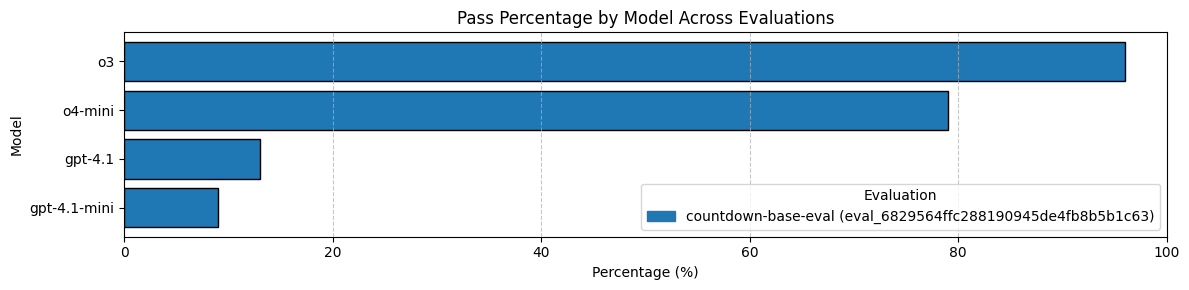

In [11]:
# load a completed evaluation
eval_id = "eval_6829564ffc288190945de4fb8b5b1c63"
# "eval_6828e5ed77808190ad2ad8aca83313f1"

# Import the display_evaluation_summary function from the eval_utils script
from scripts.eval_utils import display_evaluation_summary

# Display the evaluation summary
await display_evaluation_summary([eval_id])

In [12]:
from scripts.eval_utils import compare_eval_runs_generic

eval_run_id_o3 = "evalrun_68295656ba5c8190b2fc62f37088b01c"
eval_run_id_o4_mini = "evalrun_6829565835b881909b0ba6c6222ade4b"


await compare_eval_runs_generic(
    eval_id_1 = eval_id,
    run_id_1 = eval_run_id_o4_mini,
    label_1 ="o4_mini",

    eval_id_2 = eval_id,
    run_id_2 = eval_run_id_o3,
    label_2 ="o3",

    filter_by="improved", # improved, degraded, same or all
    max_records=100
)


📊 Evaluation Comparison: o4_mini vs o3 | Filter: 'improved' | Improved = 19 (100.0%)

╒══════════╤══════════╤══════════════════╤══════════════════╤═════════════╤═══════════════════════════════════════╤═════════════════════════╤═════════════════╤════════════╤══════════════════╤═════════════╤══════════╕
│   Sample │   Target │ Numbers          │   o4_mini Result │   o3 Result │ o4_mini Expr                          │ o3 Expr                 │   o4_mini Score │   o3 Score │ o4_mini Status   │ o3 Status   │ Change   │
╞══════════╪══════════╪══════════════════╪══════════════════╪═════════════╪═══════════════════════════════════════╪═════════════════════════╪═════════════════╪════════════╪══════════════════╪═════════════╪══════════╡
│        4 │       13 │ [38, 42, 19, 24] │            12.87 │          13 │ (42 * 19) / (38 + 24)                 │ (19 - (24 / (42 - 38))) │               4 │          5 │ fail             │ pass        │ improved │
├──────────┼──────────┼──────────────────┼───

### 📊 Evaluation Results – Key Insights

The table below summarizes evaluation runs across four base models on the Countdown task, scored using our custom `o3-mini` model-based grader.

| Model         | Pass %   | Error % |
|---------------|----------|----------|
| **o3**        | 97.0%   | 0.0%     |
| **o4-mini**   | 76.0%    | 0.0%    |
| gpt-4.1       | 12.0%    | 0.0%     |
| gpt-4.1-mini  | 4.0%    | 0.0%     |

---

**💡 What We Learned**

1. **Reasoning models (`o3`, `o4-mini`)** vastly outperform general-purpose models on structured logic tasks.
2. **`o3` delivers perfect accuracy**, but comes with higher inference cost and latency.
3. **`o4-mini` offers a strong trade-off** between performance and efficiency — and is the best candidate for fine-tuning.
4. **RFT is available for reasoning models** like `o4-mini`, which makes them ideal for reward-based learning.
5. Although **SFT is available on gpt-4.1 and 4.1-mini**, their architecture isn't well-suited to this multi-step task structure.

---

> ✅ Next: We’ll fine-tune `o4-mini` using Reinforcement Fine-Tuning — leveraging reward signals from our grader to produce more accurate, structured, and cost-effective completions.


## 🚀 Section 4: RFT Training – Setup, Launch & Monitoring

With our system prompt, schema, and grader defined — and base model performance evaluated — we’re now ready to fine-tune `o4-mini` using **Reinforcement Fine-Tuning (RFT)**.

---

### 🧪 RFT is Sample-Efficient by Design

Unlike supervised fine-tuning, which often requires thousands of labeled examples, RFT works well with small, high-signal datasets. In this demo, we use:

- **100 training examples**
- **50 validation examples**

Each example includes:
- A full prompt (system + user message)
- Embedded `target` and `nums` fields (for use by the grader only)
- No ground-truth output — the model learns purely from **reward scores**

---

### 🔄 Workflow

1. **Prepare and convert** a small dataset into RFT-ready format
2. **Upload** the training and validation datasets to Azure OpenAI
3. **Launch** the RFT job using the Studio UI or Python SDK
4. **Monitor** training metrics like reward trends and validation scores

---

> ✅ Let’s walk through these steps now, and then evaluate the performance of our fine-tuned model.


### 🧾 Step 1: Preparing the RFT Training Dataset (Prompt + Reference Data)

Each record in the RFT dataset includes two key components:

---

#### 🗣️ `messages`: The Prompt Seen by the Model

This is the **full instruction** the model sees during training and inference. It includes:
- Task description
- Format constraints
- One or more examples
- The target and number list for that instance

This forms the basis of model behavior during completion.

---

#### 🧾 Reference Fields (`target`, `nums`)

In addition to the prompt, we include a `target` and `nums` field outside `messages`. These are:
- Used **only by the grader** during evaluation
- Sometimes redundant (they’re also embedded in the prompt), but necessary for structured scoring
- Useful for keeping model input and evaluation data logically separate

```json
{
  "messages": [
    {
      "role": "user",
      "content": "You are an expert in arithmetic problem solving... \nTarget: \"39\" Numbers: \"[65, 9, 35]\""
    }
  ],
  "target": "39",
  "nums": "[65, 9, 35]"
}


In [13]:
from datasets import load_dataset
from scripts.dataset_utils import save_dataset_as_jsonl, convert_to_rft_dataset


# File paths
train_raw_path = "data/countdown_train_raw.jsonl"
valid_raw_path = "data/countdown_valid_raw.jsonl"
train_rft_path = "data/countdown_train_100.jsonl"
valid_rft_path = "data/countdown_valid_50.jsonl"

# Load and split the raw dataset
dataset = load_dataset("predibase/countdown", split="train")
train_split = dataset.select(range(500))
valid_split = dataset.select(range(500, 1000))

# Save raw JSONL files
save_dataset_as_jsonl(train_split, train_raw_path)
save_dataset_as_jsonl(valid_split, valid_raw_path)

# Convert both splits to RFT training format
convert_to_rft_dataset(train_raw_path, train_rft_path, instruction, max_records=100)
convert_to_rft_dataset(valid_raw_path, valid_rft_path, instruction, max_records=50)

print(f"✅ Train set saved to: {train_rft_path}")
print(f"✅ Validation set saved to: {valid_rft_path}")



✅ Saved 245 records to data/countdown_train_raw.jsonl in evaluation format (only samples with 4 nums)
✅ Saved 256 records to data/countdown_valid_raw.jsonl in evaluation format (only samples with 4 nums)
✅ Converted 100 records to RFT format and saved to data/countdown_train_100.jsonl
✅ Converted 50 records to RFT format and saved to data/countdown_valid_50.jsonl
✅ Train set saved to: data/countdown_train_100.jsonl
✅ Validation set saved to: data/countdown_valid_50.jsonl


### ☁️ Step 2: Uploading Train and Validation Sets to Azure OpenAI

Before we launch the RFT job, we upload our training and validation datasets.

Both files are in **RFT-ready JSONL format**:
- Prompt: `messages` array with the full system + user message
- Reference: `target` and `nums` fields for evaluation
- No output — model completions will be scored dynamically using the grader

We’ll also preview a sample record to verify formatting.


In [19]:
from scripts.io_utils import upload_file
import json

# File paths
train_rft_path = "data/countdown_train_100.jsonl"
valid_rft_path = "data/countdown_valid_50.jsonl"

# Upload both files to Azure OpenAI
train_file_id = await upload_file("countdown_train_100.jsonl", train_rft_path, purpose="fine-tune")
valid_file_id = await upload_file("countdown_valid_50.jsonl", valid_rft_path, purpose="fine-tune")

print(f"📤 Uploaded Train File ID : {train_file_id}")
print(f"📤 Uploaded Valid File ID : {valid_file_id}")

# Preview one sample record from the train set
with open(train_rft_path, "r") as f:
    sample = json.loads(f.readline())

print("📝 Sample RFT Training Record:\n")
print(json.dumps(sample, indent=2, ensure_ascii=False, sort_keys=False))


Using Azure API for file upload...
File 'countdown_train_100.jsonl' already exists on Azure. Returning existing file ID.
Using Azure API for file upload...
File 'countdown_valid_50.jsonl' already exists on Azure. Returning existing file ID.
📤 Uploaded Train File ID : file-56bec418303b4a6bbdbc5e4422def027
📤 Uploaded Valid File ID : file-2fbb22586d1b433faed79fab3e10e5a7
📝 Sample RFT Training Record:

{
  "messages": [
    {
      "role": "user",
      "content": "You are an expert in arithmetic problem solving. Given a target number and a list of numbers, your task is to combine all of the numbers exactly once using addition (+), subtraction (-), multiplication (x), or division (÷) to reach the target.\n\n- You must use every number exactly once.\n- Use parentheses as needed to control the order of operations.\n- Return only a valid JSON object with the following exact syntax:\n  {\n    \"expression\": \"...\",\n    \"result\": \"...\"\n  }\n- Both the expression and the result must be r

### 🚀 Step 3: Submitting the RFT Job via Azure OpenAI SDK

We now submit the RFT job using the Azure OpenAI SDK.

---

#### 🔧 Configuration Summary

- **Base Model**: `o4-mini-2025-04-16`
- **Grader**: `o3-mini` (model-based, score 0–5)
- **Response Schema**: Structured JSON format
- **Training File**: 100 examples
- **Validation File**: 50 examples

#### ⚙️ RFT Hyperparameters
- `n_epochs`: 1
- `batch_size`: 4
- `eval_interval`: 5
- `eval_samples`: 2
- `reasoning_effort`: `"medium"`
- `learning_rate_multiplier`: 2

This setup gives us a fast and focused way to validate whether RFT meaningfully improves performance — without overfitting or excessive cost.


In [ ]:
import os
from dotenv import load_dotenv
from openai import AzureOpenAI

load_dotenv(override=True)

# API keys and endpoint
AZURE_API_KEY = os.getenv("AZURE_API_KEY")
AZURE_API_ENDPOINT = os.getenv("AZURE_API_ENDPOINT")
# Python grader is supported in 2025-04-01-preview version or v1
API_VERSION = "2025-04-01-preview"

client = AzureOpenAI(api_key=AZURE_API_KEY, azure_endpoint=AZURE_API_ENDPOINT, api_version=API_VERSION)

method = {
		"type": "reinforcement",
		"reinforcement": {
			"hyperparameters": {
				"eval_interval": 5,
				"eval_samples": 2,
				"reasoning_effort": "medium",
				"n_epochs": 1,
				"batch_size": 4,
				"learning_rate_multiplier": 2
			},
			"grader": custom_grader,
          	"response_format": response_schema
        }
    }   

finetune_job = client.fine_tuning.jobs.create(
            model="o4-mini-2025-04-16",
            training_file=train_file_id,
            validation_file=valid_file_id,
            method=method,
            suffix="countdown-rft")


print(f"Fine-tuning job submitted. Job ID: {finetune_job.id}")


Fine-tuning job submitted. Job ID: ftjob-861fd63fa11844208b7e5f7d8619361f


### 📈 Step 4: Monitoring the RFT Job in Azure OpenAI Studio

Once the RFT job is submitted, you can monitor its progress in the Azure OpenAI Studio under the **Fine-tuning** tab.

---

**📊 Reward Curves**

- *Training Reward*: Average score (from the grader) across training completions
- *Validation Reward*: Same metric, but tracked on the held-out validation set

> Ideally, you want to see upward trends or steady plateaus — indicating the model is learning to optimize completions over time.

---

### 🚀 Step 5: Deploying the Fine-Tuned Model

After the RFT job completes successfully, the fine-tuned model must be **deployed** to make it callable via the completions or evaluation APIs.

In Azure OpenAI Studio create a new deployment using the model suffix (e.g., `ft:o4-mini-countdown-rft`)


> ✅ Once deployed, we can run evaluations using this fine-tuned model and compare results against the base models.


## 🧠 Section 5: Evaluating the Fine-Tuned Model & Comparing Results

Now that RFT is complete and our fine-tuned `ft:o4-mini` model is deployed, we evaluate it on the **same test set** and using the **same model-based grader** as before.

We'll:
1. Reuse the **existing evaluation file**
2. Run the `evaluate()` API on the fine-tuned deployment
3. Add results to our earlier comparison table

---

### ❓ Key Questions

- Did the fine-tuned model improve pass rates?
- Is it now competitive with `o3`?
- Does it maintain low error rates while using fewer resources?

> ✅ This step helps us confirm if RFT successfully aligned the model toward high-quality, constrained reasoning — without overfitting or regressions.


In [ ]:
from scripts.eval_utils import create_eval_python_grader, create_eval_run

ft_eval_id = await create_eval_python_grader("python-grader-countdown-rft", pass_threshold=5)

print(f"📊 Evaluation created with ID: {ft_eval_id}")

# Define model deployments to evaluate
RUN_MODEL_DEPLOYMENTS = [
    # "o3", 
    # "o4-mini-2025-04-16-countdown", # replace with your ft model deployment name
    "o4-mini-2025-04-16-ft-079fde37333642dfa64b4a2631e85695"
]

# Launch eval runs for each model
for deployment in RUN_MODEL_DEPLOYMENTS:
    await create_eval_run(ft_eval_id, eval_file_id, deployment, system_prompt=instruction)

print(f"🚀 Evaluation runs launched for models: {', '.join(RUN_MODEL_DEPLOYMENTS)}")
print(f"📌 Evaluation ID: {ft_eval_id}")

Evaluation created successfully with ID: eval_68429953aca48190b1263ce7324ec9ee
📊 Evaluation created with ID: eval_68429953aca48190b1263ce7324ec9ee
Create Eval Run Status for o4-mini-2025-04-16-ft-079fde37333642dfa64b4a2631e85695: 201
🚀 Evaluation runs launched for models: o4-mini-2025-04-16-ft-079fde37333642dfa64b4a2631e85695
📌 Evaluation ID: eval_68429953aca48190b1263ce7324ec9ee


Get Evaluation Runs: eval_6828e5ed77808190ad2ad8aca83313f1
Get Evaluation Runs: eval_6828e2efff5c8190b84f170b5246d4e9

Combined Evaluation Summary
                                  Run ID                        Run Name           Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID     Evaluation Name
evalrun_6828e5ef03588190b80b60064ed8b259                           sc_o3              o3 completed                97.0                  0.0 eval_6828e5ed77808190ad2ad8aca83313f1 countdown-base-eval
evalrun_6828e2f1a85c8190951f31be00e605b2 sc_o4-mini-2025-04-16-countdown o4-mini-2025-04 completed                86.0                  0.0 eval_6828e2efff5c8190b84f170b5246d4e9   countdown-ft-eval
evalrun_6828e5f06690819091705269697fa5e5                      sc_o4-mini         o4-mini completed                76.0                  0.0 eval_6828e5ed77808190ad2ad8aca83313f1 countdown-base-eval
evalrun_6828e5f1fda88190aa273140194a7380                     

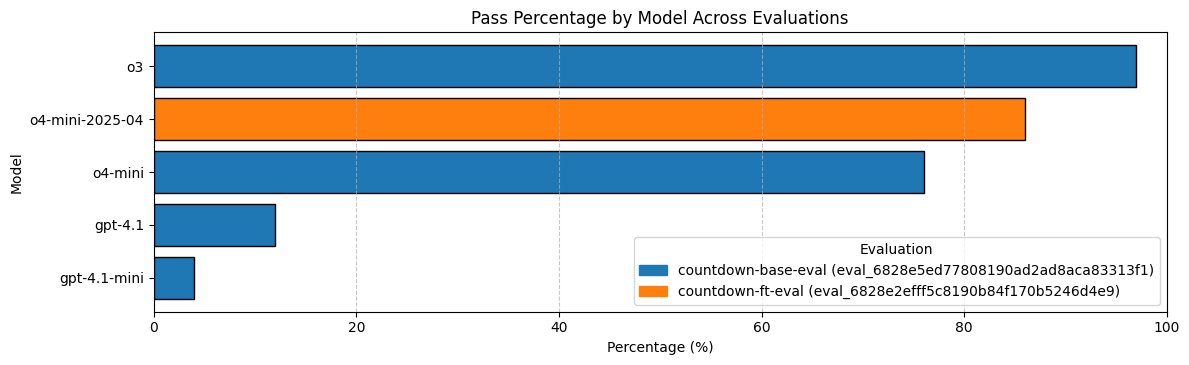

In [1]:
# Import the display_evaluation_summary function from the eval_utils script
from scripts.eval_utils import display_evaluation_summary

# Load the completed evaluation IDs from the config file
eval_id = "eval_6828e5ed77808190ad2ad8aca83313f1"
ft_eval_id = "eval_6828e2efff5c8190b84f170b5246d4e9"

# Display the evaluation summary
eval_ids = [eval_id, ft_eval_id]
await display_evaluation_summary(eval_ids)

In [2]:
from scripts.eval_utils import compare_eval_runs_generic

eval_run_id_o3 = "evalrun_6828e5ef03588190b80b60064ed8b259"
eval_run_id_ft_o4_mini = "evalrun_6828e2f1a85c8190951f31be00e605b2"
eval_run_id_o4_mini = "evalrun_6828e5f06690819091705269697fa5e5"

await compare_eval_runs_generic(
    eval_id_1= eval_id,
    run_id_1= eval_run_id_o4_mini,
    label_1="o4_mini",

    eval_id_2= ft_eval_id,
    run_id_2= eval_run_id_ft_o4_mini,
    label_2="o4_mini_ft",

    filter_by="improved", # improved, degraded, same or all
    max_records=100
)




📊 Evaluation Comparison: o4_mini vs o4_mini_ft | Filter: 'improved' | Improved = 21 (100.0%)

╒══════════╤══════════╤══════════════════╤══════════════════╤═════════════════════╤═════════════════════════════╤══════════════════════════════╤═════════════════╤════════════════════╤══════════════════╤═════════════════════╤══════════╕
│   Sample │   Target │ Numbers          │ o4_mini Result   │   o4_mini_ft Result │ o4_mini Expr                │ o4_mini_ft Expr              │   o4_mini Score │   o4_mini_ft Score │ o4_mini Status   │ o4_mini_ft Status   │ Change   │
╞══════════╪══════════╪══════════════════╪══════════════════╪═════════════════════╪═════════════════════════════╪══════════════════════════════╪═════════════════╪════════════════════╪══════════════════╪═════════════════════╪══════════╡
│        1 │      100 │ [45, 29, 15, 68] │ 99.0             │              100    │ ((45 + 15) + (68 - 29))     │ ((29 + (45 ÷ 15)) + 68)      │               4 │                  5 │ fail         

### 📈 Updated Performance Snapshot

Here’s how the fine-tuned `o4-mini` model performs after RFT, compared to base models:

| Model              | Pass %   | Error % |
|-------------------|----------|----------|
| **o3**             | 97.0%   | 0.0%     |
| **ft:o4-mini**     | 86.0%    | 0.0%     |
| o4-mini (base)     | 76.0%    | 0.0%    |
| gpt-4.1            | 12.0%    | 0.0%     |
| gpt-4.1-mini       | 4.0%    | 0.0%     |

---

### 🔍 What Changed?

- **13.1% pass rate improvement** for `ft:o4-mini` vs. `o4-mini` base
- The fine-tuned model now **approaches o3’s performance** with far lower inference cost and latency

---

> ✅ RFT helped align `o4-mini` more tightly to the task, with better structure, constraint-following, and fewer formatting failures.


## 🎯 Key Takeaways

In this demo, we explored the power of **Reinforcement Fine-Tuning (RFT)** on a reasoning-heavy task using `o4-mini` on Azure OpenAI.

---

### ✅ What We Did

- Used the **Countdown** dataset — a structured reasoning task with multiple valid outputs
- Defined a **system prompt**, **response schema**, and a custom **model-based grader**
- Evaluated **base models** (reasoning vs non-reasoning)
- Fine-tuned `o4-mini` using **just 100 examples**
- Re-evaluated and showed **significant improvement** in both output quality and pass rate

---

### 💡 Why RFT Worked

- **No labels required** — the model learned from reward scores
- **Multiple correct answers** — RFT handled ambiguity better than SFT
- **Task constraints enforced by reward** — not hardcoded rules
- **Lightweight + fast** — trained on a small dataset with clear gains

---

### 🔁 Generalization Potential

This pattern is useful across tasks like:
- Code generation and validation
- Form-filling with strict structure
- Math, tutoring, or instruction-following
- Safety alignment (via preference or structured grading)

---

> 🎓 **Smaller models + structured tasks + clear rewards = big wins.**  
> With Azure OpenAI and RFT, it’s now easy to teach models to reason better — without needing labeled data.

![Title Diagram](./images/outro.png)
